In [1]:
import gc
from datetime import datetime, timedelta,date
import warnings
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection,johnson_lindenstrauss_min_dim
from sklearn.decomposition import PCA, FastICA,NMF,LatentDirichletAllocation,IncrementalPCA,MiniBatchSparsePCA
from sklearn.decomposition import TruncatedSVD,FactorAnalysis,KernelPCA

import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

#settings
warnings.filterwarnings('ignore')
np.random.seed(2018)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
historical_trans_df = pd.read_csv('input/historical_transactions.csv')
new_merchant_trans_df = pd.read_csv('input/new_merchant_transactions.csv')
merchant_df = pd.read_csv('input/merchants.csv')

In [4]:
def get_hist_default_prorcessing(df):
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2}) 
    df['month_diff'] = ((datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    return df

In [5]:
def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t
    
def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

In [6]:
historical_trans_df = get_hist_default_prorcessing(historical_trans_df)
new_merchant_trans_df = get_hist_default_prorcessing(new_merchant_trans_df)

In [7]:
historical_trans_df = pd.get_dummies(historical_trans_df, columns=['category_2', 'category_3'])
new_merchant_trans_df = pd.get_dummies(new_merchant_trans_df, columns=['category_2', 'category_3'])

In [8]:
#historical_trans_df = reduce_mem_usage(historical_trans_df)
#new_merchant_trans_df = reduce_mem_usage(new_merchant_trans_df)

In [9]:
authorized_transactions = historical_trans_df[historical_trans_df['authorized_flag'] == 1]
historical_transactions = historical_trans_df[historical_trans_df['authorized_flag'] == 0]

In [10]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

def get_train_default_prorcessing(df):
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['quarter'] = df['first_active_month'].dt.quarter
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime(2018, 2, 1).date() - df['first_active_month'].dt.date).dt.days
    return df

train_df = get_train_default_prorcessing(train_df)
test_df = get_train_default_prorcessing(test_df)

train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

all_df = pd.concat([train_df,test_df])

In [11]:
group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
all_df = all_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
all_df = all_df.merge(group_df, on=['elapsed_time'], how='left')

['dayofyear'] outliers ['mean']
['elapsed_time'] outliers ['mean']


In [13]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'purchase_amount',['sum','max','min','mean','std'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(historical_trans_df,['card_id'], 'installments',['sum','max','min','mean','std'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'purchase_amount',['sum','max','min','mean','std'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'installments',['sum','max','min','mean','std'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] purchase_amount ['sum', 'max', 'min', 'mean', 'std']
['card_id'] installments ['sum', 'max', 'min', 'mean', 'std']
['card_id'] purchase_amount ['sum', 'max', 'min', 'mean', 'std']
['card_id'] installments ['sum', 'max', 'min', 'mean', 'std']


In [14]:
group_df = groupby_helper(historical_transactions,['card_id'], 'month',['nunique','max','min','mean','std'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(authorized_transactions,['card_id'], 'month',['nunique','max','min','mean','std'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'month',['nunique','max','min','mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] month ['nunique', 'max', 'min', 'mean', 'std']
['card_id'] month ['nunique', 'max', 'min', 'mean', 'std']
['card_id'] month ['nunique', 'max', 'min', 'mean']


In [15]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'month_lag',['max','min','mean','std'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'month_lag',['max','min','mean','std'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] month_lag ['max', 'min', 'mean', 'std']
['card_id'] month_lag ['max', 'min', 'mean', 'std']


In [16]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'merchant_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] merchant_id ['nunique']


In [17]:
group_df = groupby_helper(historical_transactions,['card_id'], 'merchant_category_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(authorized_transactions,['card_id'], 'merchant_category_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] merchant_category_id ['nunique']
['card_id'] merchant_category_id ['nunique']


In [18]:
group_df = groupby_helper(historical_transactions,['card_id'], 'subsector_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(authorized_transactions,['card_id'], 'subsector_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] subsector_id ['nunique']
['card_id'] subsector_id ['nunique']


In [19]:
group_df = groupby_helper(historical_transactions,['card_id'], 'state_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(authorized_transactions,['card_id'], 'state_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] state_id ['nunique']
['card_id'] state_id ['nunique']


In [20]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'city_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] city_id ['nunique']


In [21]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'merchant_category_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'subsector_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'state_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] merchant_category_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] state_id ['nunique']


In [22]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'month_diff',['mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] month_diff ['mean']


In [23]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'month_diff',['mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] month_diff ['mean']


In [24]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'category_1',['sum','mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] category_1 ['sum', 'mean']


In [25]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'category_1',['sum','mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] category_1 ['sum', 'mean']


In [26]:
group_df = groupby_helper(historical_transactions,['card_id'], 'card_id',['size'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(authorized_transactions,['card_id'], 'card_id',['size'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] card_id ['size']
['card_id'] card_id ['size']


In [27]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'card_id',['size'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] card_id ['size']


In [28]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'category_2_1.0',['mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(historical_trans_df,['card_id'], 'category_2_2.0',['mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(historical_trans_df,['card_id'], 'category_2_3.0',['mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(historical_trans_df,['card_id'], 'category_2_4.0',['mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(historical_trans_df,['card_id'], 'category_2_5.0',['mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] category_2_1.0 ['mean']
['card_id'] category_2_2.0 ['mean']
['card_id'] category_2_3.0 ['mean']
['card_id'] category_2_4.0 ['mean']
['card_id'] category_2_5.0 ['mean']


In [29]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'category_2_1.0',['mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'category_2_2.0',['mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'category_2_3.0',['mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'category_2_4.0',['mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'category_2_5.0',['mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] category_2_1.0 ['mean']
['card_id'] category_2_2.0 ['mean']
['card_id'] category_2_3.0 ['mean']
['card_id'] category_2_4.0 ['mean']
['card_id'] category_2_5.0 ['mean']


In [90]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'purchase_date',['min', 'max'])
group_df['card_id_purchase_date_min'] = pd.DatetimeIndex(group_df['card_id_purchase_date_min']).astype(np.int64) * 1e-9
group_df['card_id_purchase_date_max'] = pd.DatetimeIndex(group_df['card_id_purchase_date_max']).astype(np.int64) * 1e-9
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] purchase_date ['min', 'max']


In [31]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'purchase_date',['min', 'max'],'new_hist')
group_df['new_hist_card_id_purchase_date_min'] = pd.DatetimeIndex(group_df['new_hist_card_id_purchase_date_min']).astype(np.int64) * 1e-9
group_df['new_hist_card_id_purchase_date_max'] = pd.DatetimeIndex(group_df['new_hist_card_id_purchase_date_max']).astype(np.int64) * 1e-9
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] purchase_date ['min', 'max']


In [32]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group =  aggregate_per_month(authorized_transactions) 

In [33]:
all_df = all_df.merge(final_group, on=['card_id'], how='left')

In [34]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [35]:
additional_fields = successive_aggregates(new_merchant_trans_df, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_merchant_trans_df, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_merchant_trans_df, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_merchant_trans_df, 'category_1', 'installments'),
                                            on = 'card_id', how='left')
all_df = all_df.merge(additional_fields, on=['card_id'], how='left')

In [104]:
historical_trans_df['reference_date'] = (historical_trans_df['year']+(historical_trans_df['month']-historical_trans_df['month_lag'])//12)
historical_trans_df['reference_date'] = historical_trans_df['reference_date'].astype(np.int64)
historical_trans_df['reference_date'] = historical_trans_df['reference_date']*10000
historical_trans_df['reference_date'] =historical_trans_df['reference_date'] +((historical_trans_df['month']-historical_trans_df['month_lag'])%12+1)*100+1
group_df = groupby_helper(historical_trans_df,['card_id'],'reference_date',['max'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
all_df.rename(columns={'card_id_reference_date_max':'reference_date'},inplace=True)

all_df['reference_date'] = pd.to_datetime(all_df['reference_date'],yearfirst=True,format='%Y%m%d')
all_df['reference_to_firstactive'] = (all_df['reference_date'] - all_df['first_active_month']).dt.days
all_df['reference_date'] = pd.DatetimeIndex(all_df['reference_date']).\
                                      astype(np.int64) * 1e-9

['card_id'] reference_date ['max']


In [105]:
historical_trans_df['reference_date2'] = (historical_trans_df['year']+(historical_trans_df['month']-historical_trans_df['month_lag'])//12)
historical_trans_df['reference_date2'] = historical_trans_df['reference_date2'].astype(np.int64)
historical_trans_df['reference_date2'] = historical_trans_df['reference_date2']*100
historical_trans_df['reference_date2'] =historical_trans_df['reference_date2'] +((historical_trans_df['month']-historical_trans_df['month_lag'])%12+1)*1
group_df = groupby_helper(historical_trans_df,['card_id'],'reference_date2',['max'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
all_df.rename(columns={'card_id_reference_date2_max':'reference_date2'},inplace=True)

all_df['year'] = all_df['first_active_month'].dt.year
all_df['year_month'] = all_df['year']*100 + all_df['month']
all_df['diff_reference_date'] = 12*(all_df['reference_date2']//100 - all_df['year_month']//100) + (all_df['reference_date2']%100 - all_df['year_month']%100)
del all_df['year']
del all_df['year_month']

['card_id'] reference_date2 ['max']


In [155]:
song_train_feature = pd.read_csv('input/train_for_yeonmin')
song_test_feature = pd.read_csv('input/test_for_yeonmin')

In [157]:
song_all_df = pd.concat([song_train_feature,song_test_feature])

In [159]:
song_all_df.shape

(325540, 11)

In [163]:
song_all_df = song_all_df.reset_index(drop=True)

In [164]:
all_df = pd.concat([all_df,song_all_df], axis=1)

In [149]:
group_df = groupby_helper(all_df,['diff_reference_date'],'target',['min'])
all_df = all_df.merge(group_df, on=['diff_reference_date'], how='left')

['diff_reference_date'] target ['min']


### Feature 삭제 할 때 사용!
사용 금지

In [175]:
for col in all_df.columns:
    if col.find('merchant_id_entropy') != -1:
        print(col)
        del all_df[col]

merchant_id_entropy


merchant_id_entropy

In [176]:

train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]
#train_df = train_df.reset_index()
#test_df = test_df.reset_index()

#group_df = groupby_helper(train_df,['reference_to_firstactive'], 'target',['median'])
#train_df = train_df.merge(group_df, on=['reference_to_firstactive'], how='left')
#test_df = test_df.merge(group_df, on=['reference_to_firstactive'], how='left')

#del train_df['reference_date'], test_df['reference_date']

train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
train_columns

['dayofweek',
 'dayofyear',
 'elapsed_time',
 'feature_1',
 'feature_2',
 'feature_3',
 'month',
 'quarter',
 'weekofyear',
 'dayofyear_outliers_mean',
 'elapsed_time_outliers_mean',
 'card_id_purchase_amount_sum',
 'card_id_purchase_amount_max',
 'card_id_purchase_amount_min',
 'card_id_purchase_amount_mean',
 'card_id_purchase_amount_std',
 'card_id_installments_sum',
 'card_id_installments_max',
 'card_id_installments_min',
 'card_id_installments_mean',
 'card_id_installments_std',
 'new_hist_card_id_purchase_amount_sum',
 'new_hist_card_id_purchase_amount_max',
 'new_hist_card_id_purchase_amount_min',
 'new_hist_card_id_purchase_amount_mean',
 'new_hist_card_id_purchase_amount_std',
 'new_hist_card_id_installments_sum',
 'new_hist_card_id_installments_max',
 'new_hist_card_id_installments_min',
 'new_hist_card_id_installments_mean',
 'new_hist_card_id_installments_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month

In [177]:
# PCA
n_comp = 12

# ICA
ica = FastICA(n_components=n_comp, random_state=2019)
ica2_results_train = ica.fit_transform(train_df[train_columns].fillna(-1))
ica2_results_test = ica.transform(test_df[train_columns].fillna(-1))

for i in range(1, n_comp+1):
    train_df['ica_' + str(i)] = ica2_results_train[:,i-1]
    test_df['ica_' + str(i)] = ica2_results_test[:, i-1]
    train_columns.append('ica_' + str(i))

train_columns

['dayofweek',
 'dayofyear',
 'elapsed_time',
 'feature_1',
 'feature_2',
 'feature_3',
 'month',
 'quarter',
 'weekofyear',
 'dayofyear_outliers_mean',
 'elapsed_time_outliers_mean',
 'card_id_purchase_amount_sum',
 'card_id_purchase_amount_max',
 'card_id_purchase_amount_min',
 'card_id_purchase_amount_mean',
 'card_id_purchase_amount_std',
 'card_id_installments_sum',
 'card_id_installments_max',
 'card_id_installments_min',
 'card_id_installments_mean',
 'card_id_installments_std',
 'new_hist_card_id_purchase_amount_sum',
 'new_hist_card_id_purchase_amount_max',
 'new_hist_card_id_purchase_amount_min',
 'new_hist_card_id_purchase_amount_mean',
 'new_hist_card_id_purchase_amount_std',
 'new_hist_card_id_installments_sum',
 'new_hist_card_id_installments_max',
 'new_hist_card_id_installments_min',
 'new_hist_card_id_installments_mean',
 'new_hist_card_id_installments_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month

In [178]:
train = train_df.copy()
target = train['target']
del train['target']

# categorical_feats = ['feature_2', 'feature_3']

train.shape

(201917, 157)

In [179]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "random_state": 2019}

#prepare fit model with cross-validation
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):
    strLog = "fold {}".format(fold_+1)
    print(strLog)
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv_score = np.sqrt(mean_squared_error(oof, target))
print(cv_score)

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.60912	valid_1's rmse: 3.69102
[200]	training's rmse: 3.51927	valid_1's rmse: 3.66086
[300]	training's rmse: 3.46588	valid_1's rmse: 3.65114
[400]	training's rmse: 3.42343	valid_1's rmse: 3.64741
[500]	training's rmse: 3.38607	valid_1's rmse: 3.64553
[600]	training's rmse: 3.3545	valid_1's rmse: 3.64463
[700]	training's rmse: 3.32537	valid_1's rmse: 3.6438
Early stopping, best iteration is:
[684]	training's rmse: 3.32958	valid_1's rmse: 3.6436
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.60595	valid_1's rmse: 3.6974
[200]	training's rmse: 3.51661	valid_1's rmse: 3.6735
[300]	training's rmse: 3.45942	valid_1's rmse: 3.66375
[400]	training's rmse: 3.41739	valid_1's rmse: 3.65964
[500]	training's rmse: 3.38143	valid_1's rmse: 3.65674
[600]	training's rmse: 3.34993	valid_1's rmse: 3.65519
[700]	training's rmse: 3.32129	valid_1's rmse: 3.65394
[800]

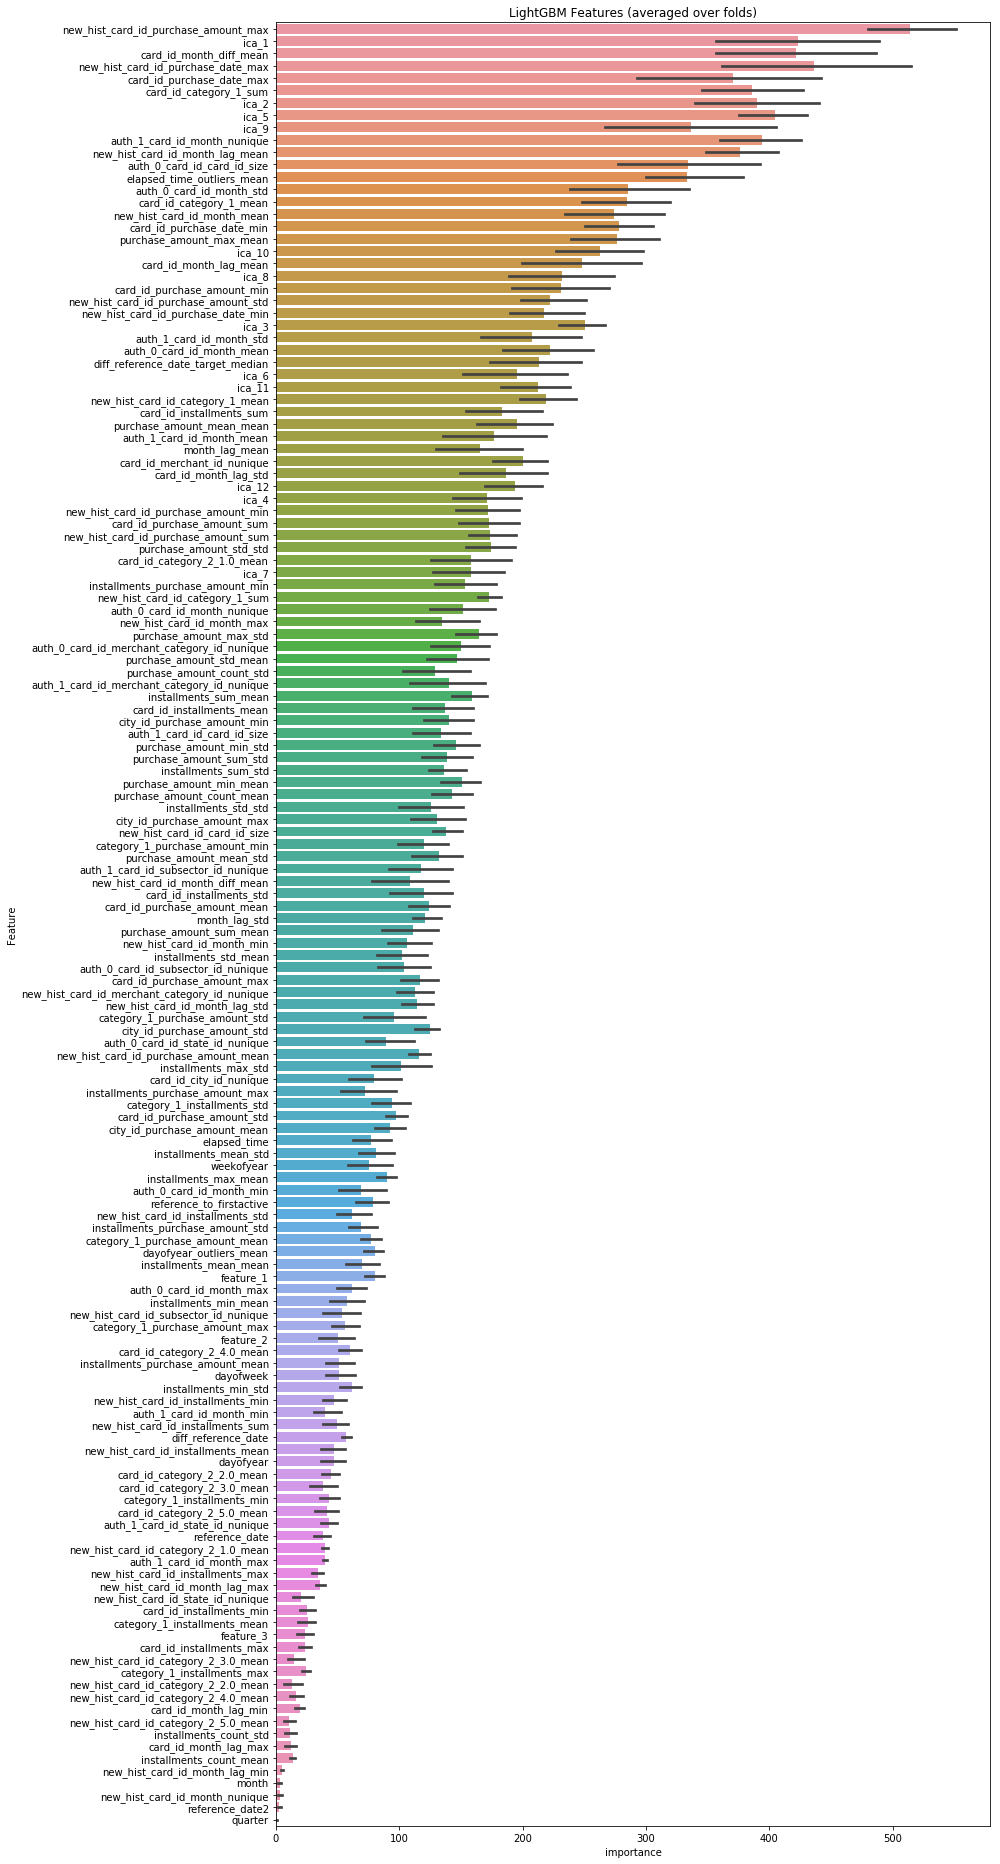

In [143]:
filename = '{}_cv{:.6f}'.format(datetime.now().strftime('%Y%m%d_%H%M%S'), cv_score)

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('fi/{}_lgbm_importances.png'.format(filename))

In [359]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = predictions
#sub_df.loc[sub_df['target']<-9,'target'] = -33.21928095
sub_df.to_csv("output/submission_{}.csv".format(filename), index=False)

    실패한 피쳐

In [493]:
all_df['card_id_total'] = all_df['auth_0_card_id_card_id_size'] + all_df['auth_1_card_id_card_id_size'] + all_df['new_hist_card_id_card_id_size']
all_df['card_id_diff'] = all_df['auth_0_card_id_card_id_size'] + all_df['auth_1_card_id_card_id_size'] - all_df['new_hist_card_id_card_id_size']
all_df['card_id_ratio'] = (all_df['auth_0_card_id_card_id_size'] + all_df['auth_1_card_id_card_id_size'])/all_df['new_hist_card_id_card_id_size']

### 위에까지 확정된 Feature

In [335]:
group_df = groupby_helper(historical_trans_df,['card_id','merchant_id'],['purchase_date'],['size'])
temp = group_df.groupby(['card_id'])['card_id_merchant_id_purchase_date_size'].apply(pd.DataFrame.kurt)
temp = temp.reset_index()
temp.columns = ['card_id','card_id_merchant_id_purchase_date_size_kurtosis']
all_df = all_df.merge(temp, on='card_id', how='left')

['card_id', 'merchant_id'] ['purchase_date'] ['size']


In [ ]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'purchase_date',['min', 'max'],'temp_temp')
all_df = all_df.merge(group_df, on='card_id', how='left')
all_df['new_hist_hist_first_buy'] = (all_df['new_hist_card_id_purchase_date_min'] - all_df['first_active_month']).dt.days
all_df['new_hist_hist_last_buy'] = (all_df['new_hist_card_id_purchase_date_max'] - all_df['first_active_month']).dt.days
del all_df['card_id_purchase_date_min'], all_df['card_id_purchase_date_max']

In [508]:
all_df['first_active_month'] = pd.DatetimeIndex(all_df['first_active_month']).\
                                      astype(np.int64) * 1e-9

In [529]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'hour',['mean'])
all_df = all_df.merge(group_df, on='card_id', how='left')

group_df = groupby_helper(historical_trans_df,['card_id'], 'weekofyear',['mean'])
all_df = all_df.merge(group_df, on='card_id', how='left')

['card_id'] hour ['mean']
['card_id'] weekofyear ['mean']


In [ ]:
all_df['first_active_month'].

In [500]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'weekofyear',['nunique', 'mean'])
all_df = all_df.merge(group_df, on='card_id', how='left')

['card_id'] weekofyear ['nunique', 'mean', 'min', 'max']


In [ ]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'weekofyear',['nunique', 'mean'],'new_hist')
all_df = all_df.merge(group_df, on='card_id', how='left')

In [467]:
temp = groupby_helper(historical_trans_df,['card_id','month_lag'], 'purchase_amount',['count', 'sum', 'mean', 'min', 'max', 'std'])
for col in ['card_id_month_lag_purchase_amount_count',
       'card_id_month_lag_purchase_amount_sum',
       'card_id_month_lag_purchase_amount_mean',
       'card_id_month_lag_purchase_amount_min',
       'card_id_month_lag_purchase_amount_max',
       'card_id_month_lag_purchase_amount_std']:
    group_df = groupby_helper(temp,['card_id'], col,['mean','std'])
    all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id', 'month_lag'] purchase_amount ['count', 'sum', 'mean', 'min', 'max', 'std']
['card_id'] card_id_month_lag_purchase_amount_count ['mean', 'std']
['card_id'] card_id_month_lag_purchase_amount_sum ['mean', 'std']
['card_id'] card_id_month_lag_purchase_amount_mean ['mean', 'std']
['card_id'] card_id_month_lag_purchase_amount_min ['mean', 'std']
['card_id'] card_id_month_lag_purchase_amount_max ['mean', 'std']
['card_id'] card_id_month_lag_purchase_amount_std ['mean', 'std']


In [421]:
new_merchant_trans_df.loc[:, 'purchase_date'] = pd.DatetimeIndex(new_merchant_trans_df['purchase_date']).\
                                      astype(np.int64) * 1e-9

In [419]:
historical_trans_df.loc[:, 'purchase_date'] = pd.DatetimeIndex(historical_trans_df['purchase_date']).\
                                      astype(np.int64) * 1e-9

In [436]:
historical_transactions.loc[:, 'purchase_date'] = pd.DatetimeIndex(historical_transactions['purchase_date']).\
                                      astype(np.int64) * 1e-9

In [437]:
authorized_transactions.loc[:, 'purchase_date'] = pd.DatetimeIndex(authorized_transactions['purchase_date']).\
                                      astype(np.int64) * 1e-9

In [446]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'purchase_date',['min', 'max'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] purchase_date ['min', 'max']


In [440]:
group_df = groupby_helper(historical_transactions,['card_id'], 'purchase_date',[np.ptp,'min', 'max'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(authorized_transactions,['card_id'], 'purchase_date',[np.ptp,'min', 'max'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')


['card_id'] purchase_date [<function ptp at 0x7f93dc0ad950>, 'min', 'max']
['card_id'] purchase_date [<function ptp at 0x7f93dc0ad950>, 'min', 'max']


In [50]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'category_3_0.0',['mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(historical_trans_df,['card_id'], 'category_3_1.0',['mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(historical_trans_df,['card_id'], 'category_3_2.0',['mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] category_3_0.0 ['mean']
['card_id'] category_3_1.0 ['mean']
['card_id'] category_3_2.0 ['mean']


In [51]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'category_3_0.0',['mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'category_3_1.0',['mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'category_3_2.0',['mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] category_3_0.0 ['mean']
['card_id'] category_3_1.0 ['mean']
['card_id'] category_3_2.0 ['mean']


In [409]:
group_df = groupby_helper(historical_transactions,['card_id'], 'category_3_0.0',['mean'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(authorized_transactions,['card_id'], 'category_3_0.0',['mean'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(historical_transactions,['card_id'], 'category_3_1.0',['mean'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(authorized_transactions,['card_id'], 'category_3_1.0',['mean'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(historical_transactions,['card_id'], 'category_3_2.0',['mean'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(authorized_transactions,['card_id'], 'category_3_2.0',['mean'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] category_3_0.0 ['mean']
['card_id'] category_3_0.0 ['mean']
['card_id'] category_3_1.0 ['mean']
['card_id'] category_3_1.0 ['mean']
['card_id'] category_3_2.0 ['mean']
['card_id'] category_3_2.0 ['mean']


In [129]:
group_df = groupby_helper(historical_transactions,['card_id'], 'installments',['sum','max','min','mean','std'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(authorized_transactions,['card_id'], 'installments',['sum','max','min','mean','std'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')


['card_id'] installments ['sum', 'max', 'min', 'mean', 'std']
['card_id'] installments ['sum', 'max', 'min', 'mean', 'std']


In [152]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'installments',['sum','max','min','mean'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

group_df = groupby_helper(historical_trans_df,['card_id'], 'month_lag',['max','min','mean','std'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] installments ['sum', 'max', 'min', 'mean']



UnboundLocalError: local variable 'group_df' referenced before assignment